<a href="https://colab.research.google.com/github/1900690/kyouyu/blob/main/%E3%83%9E%E3%82%B9%E3%82%AF%E7%94%BB%E5%83%8F%E3%81%8B%E3%82%89COCO%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E4%BD%9C%E6%88%90.8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#背景処理画像を作成
[remobe.bg](https://www.remove.bg/ja)にアクセスして、背景消去した画像を作成する

※フォルダには生画像、背景処理画像をセットで入れておく

##グーグルドライブから画像を入手する場合

グーグルドライブをマウント

In [37]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

##ローカルから画像を入手する場合

画像の入ったフォルダをzip化(日本語は文字化けする)、ダウンロードののち、以下のコードで解凍

In [1]:
!unzip -q nama.zip

#画像の仕分け

画像のリストを取得し、生画像、背景処理画像それぞれのフォルダに入れる

In [5]:
#参考https://kino-code.com/files-move/
import os
import shutil
#作成するフォルダネーム
file_extensions = ['jpg','png']
file_extensions 

#読み取りたいディレクトリパスを入れる
read_path = 'nama'#★読み取るフォルダネームに合わせて変更
read_files = os.listdir(read_path)

#拡張子リストを取得するフォー文を追加する。
for file_extension in file_extensions:
  if not os.path.exists(file_extension):
    os.mkdir(file_extension)

  #指定の拡張子だけのファイル名をリストを作る
  file_list = []
  for file_name in read_files:
      if file_name.endswith(file_extension):
          file_list.append(file_name)

  #read_listから、指定の拡張子のファイルだけ指定のディレクトリにコピーする
  for file_name in file_list:
      copy_from = './' + read_path + '/' + file_name    
      copy_to = './' + file_extension + '/' + file_name 
      shutil.copy2(copy_from, copy_to)

jpgフォルダには元の画像を、maskフォルダにはマスク画像を入れる。それぞれのセットごとに同じ名前を付けること

アルファチャンネル（透過度）のみ取得

In [6]:
import cv2
from matplotlib import pyplot as plt
import glob

#jpgフォルダのリストを取得
LOAD_FOLDA = 'png'
LOAD_NAME = os.listdir(LOAD_FOLDA)


#マスクフォルダを作成
SAVE_NAME = 'mask'
if not os.path.exists('./' +SAVE_NAME):
    os.mkdir('./' +SAVE_NAME)

#マスク画像を作るためのfor文
for file_name in LOAD_NAME:

  IMAGE_PATH='/content/' + LOAD_FOLDA +'/'+file_name
  image = cv2.imread(IMAGE_PATH, cv2.IMREAD_UNCHANGED)# 画像を読み込んでNumPy配列を作成
  alpha_image = image[:,:,3]# スライスを利用してアルファチャンネルのみを切り出し
  cv2.imwrite('/content/'+SAVE_NAME+'/'+file_name, alpha_image)# 画像ファイルとして保存

#マスク画像の名前を置き換えるためのfor文
FILE_PASS=glob.glob('/content/mask/*')

for name in FILE_PASS:
  #nameの名前をRENAMEへ変更
  RENAME=name.replace('-removebg-preview', '')
  os.rename(name, RENAME)

読み込んだ画像を表示する場合

・OpenCVを使って画像を読み込む cv2.imreadでOpenCV形式に変換 OpenCVはBGRなのでcvtColorでRGBに直してから表示する

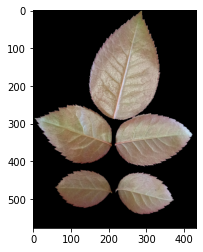

In [10]:
import cv2
from matplotlib import pyplot as plt
image_name='/content/mask/DSC_0117-removebg-preview.png'
orig = cv2.imread(image_name)
src = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(src)

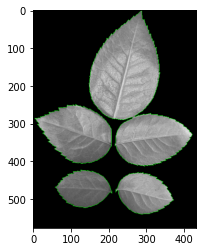

In [14]:
im = cv2.imread(image_name,flags=cv2.IMREAD_GRAYSCALE)
contours, hierarchy = cv2.findContours(im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
img = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
#drawContoursの最後の引数で輪郭描画線の太さが指定できる。
img = cv2.drawContours(img, contours, -1, (0,255,0), 1)
plt.imshow(img)
plt.show()

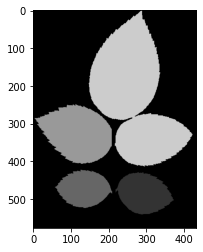

In [18]:
img2 = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
color_list = [(0,0,51),(0,0,102),(0,0,153),(0,0,204),(0,0,255)]

for i in range(len(contours)):
    cnt = contours[i]
    img2 = cv2.drawContours(img2, [cnt], 0, color_list[i], -1)
arfa_image_one=img2[:,:,2]
arfa_image = cv2.cvtColor(arfa_image_one, cv2.COLOR_GRAY2BGR)
plt.imshow(arfa_image)
plt.show()

In [20]:
print(arfa_image_one)
np.savetxt('arfa_image_one.txt', arfa_image_one, fmt ='%.0f')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


ライブラリインポート

In [7]:
import json
import collections as cl
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
import cv2
import glob
import sys
import os

関数定義

問題点

*画像の大きさをjpg,pngで合わせる必要がある 

*アノテーションの向きが上下左右逆になっている

*複数枚の葉が写った画像に対応させる必要がある

In [8]:
### https://qiita.com/harmegiddo/items/da131ae5bcddbbbde41f

def info():
    tmp = cl.OrderedDict()
    tmp["year"] = "2022"
    tmp["version"] = "1"
    tmp["description"] = "Exported from roboflow.ai"
    tmp["contributor"] = ""
    tmp["url"] ="https://public.roboflow.ai/object-detection/undefined"
    tmp["data_created"] = "2022"
    return tmp

def licenses():
    tmp = cl.OrderedDict()
    tmp["id"] = 1
    tmp["url"] = "https://creativecommons.org/licenses/by/4.0/"
    tmp["name"] = "CC BY 4.0"
    return tmp

def categories():
    tmps = []
    sup = ["none","reaf","reaf","reaf","reaf","reaf"]
    cat = ["reaf","reaf1","reaf2","reaf3","reaf4","reaf5"]

    for i in range(len(sup)):
        tmp = cl.OrderedDict()
        tmp["id"] = i
        tmp["name"] = cat[i]
        tmp["supercategory"] = sup[i]
        tmps.append(tmp)
    return tmps

def images(mask_path):
    tmps = []
    files = glob.glob(mask_path + "/*.png")
    files.sort()

    for i, file in enumerate(files):
        img = cv2.imread(file, 0)
        height, width = img.shape[:3]

        tmp = cl.OrderedDict()
        tmp["id"] = i
        tmp["license"] = 1
        tmp["file_name"] = os.path.basename(file.replace('png', 'jpg'))
        tmp["height"] = height
        tmp["width"] = width
        tmp["date_captured"] = ""
        tmps.append(tmp)
    return tmps


def annotations(mask_path):
    tmps = []

    files = glob.glob(mask_path + "/*.png")
    files.sort()
    
    for i, file in enumerate(files):
        img = cv2.imread(file, 0)
        tmp = cl.OrderedDict()
        contours = measure.find_contours(img, 0.5)
        segmentation_list = []

        for contour in contours:
            for a in contour:
                segmentation_list.append(a[0])
                segmentation_list.append(a[1])


        mask = np.array(img)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []

        for j in range(num_objs):
            pos = np.where(masks[j])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        tmp_segmentation = cl.OrderedDict()

        tmp["id"] = i
        tmp["image_id"] = i
        tmp["category_id"] = 1
        tmp["bbox"] =  [float(boxes[0][0]), float(boxes[0][1]), float(boxes[0][3] - boxes[0][1]), float(boxes[0][2] - boxes[0][0])]
        tmp["area"] = float(boxes[0][3] - boxes[0][1]) * float(boxes[0][2] - boxes[0][0])
        tmp["segmentation"] = [segmentation_list]
        tmp["iscrowd"] = 0        
        tmps.append(tmp)
    return tmps



def main(mask_path, json_name):
    query_list = ["info", "licenses", "categories", "images", "annotations"]
    js = cl.OrderedDict()
    for i in range(len(query_list)):
        tmp = ""
        # Info
        if query_list[i] == "info":
            tmp = info()
            
        # licenses
        elif query_list[i] == "licenses":
            tmp = licenses()

        elif query_list[i] == "categories":
            tmp = categories()

        elif query_list[i] == "images":
            tmp = images(mask_path)

        elif query_list[i] == "annotations":
            tmp = annotations(mask_path)

        # save it
        js[query_list[i]] = tmp

    # write
    fw = open(json_name,'w')
    json.dump(js,fw,indent=2)

main

In [9]:
#args = sys.argv
#mask_path = args[1]
mask_path =  "/content/mask"
#json_name = args[2]
json_name = "inuneko.json"

if __name__=='__main__':
    main(mask_path, json_name)

In [32]:
!cd "/content/" && zip -q "jpg.zip" -r "jpg"